In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
mpl.rcParams['savefig.dpi'] = 300

In [2]:
pre_train = 10
epoch = 3000
path = 'results/training/'
tasks = ['Push', 'Hit', 'Stack']
task_order = ['-012', '-021', '-102', '-120', '-201', '-210']
task_order_names = ['Push-Hit-Stack', 'Push-Stack-Hit', 'Hit-Push-Stack',
                    'Hit-Stack-Push','Stack-Push-Hit','Stack-Hit-Push']

legend_label = ['BLOCK', 'INTER-RAND', 'INTER-LP']
models = ['blocked', 'imtl-rand', 'imtl-lp']
model_colors = {'imtl-rand': '#009988',
                'imtl-lp': '#cc3311', 'blocked': '#ee3377'}
plot_subpath = "paperversionplot/blockedvsimtl"

In [3]:
if not os.path.exists(plot_subpath):
    os.makedirs(plot_subpath)

Lp - Ep plotting

In [4]:
# seed = 0
# model_name = "lpe-k=1-seed-{}".format(seed)
# lp_history = np.load(f'{path}/lp-values-{model_name}.npy')
# ep_history = np.load(f'{path}/ep-values-{model_name}.npy')
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].plot(lp_history[0], label='push')
# ax[0].plot(lp_history[1], label='stack')
# ax[0].plot(lp_history[2], label='hit')
# ax[0].set_title('LP history')
# ax[0].legend()
#
# ax[1].plot(ep_history[0], label='push')
# ax[1].plot(ep_history[1], label='stack')
# ax[1].plot(ep_history[2], label='hit')
# ax[1].set_title('EP history')
# ax[1].legend()
# plt.show()

In [5]:
num_seeds = 10
seeds = [8302, 2766,  257, 7600, 6657, 8226, 6841, 4908, 1321, 7857]
task_losses_seeds = np.zeros((len(task_order), num_seeds, len(models), 3, epoch + pre_train))
task_energies_seeds = np.zeros((len(task_order), num_seeds, len(models), 3))
model_losses_seeds = np.zeros((len(task_order), num_seeds, len(models), epoch + pre_train))
model_energies_seeds = np.zeros((len(task_order), num_seeds, len(models)))

In [6]:
mode = 'train'

In [7]:
# plt.figure(1)
for o, order in enumerate(task_order):
    for s, seed in enumerate(seeds):
      # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
      for i, model in enumerate(models):
        model_name = model + order if model == "blocked" else model
        loss_data = np.load('{}/plots/{}-loss-plot-seed-{}.npy'.format(path + model_name, mode, seed), allow_pickle=True)[:, :epoch + pre_train]
        energy_data = np.load('{}/plots/{}-energy-bar-epoch-{}-seed-{}.npy'.format(path + model_name, mode, epoch, seed),
                              allow_pickle=True)  # shape: task count
        avg_task_loss = np.mean(loss_data, axis=0)
        for j in range(3):  # number of tasks
            task_losses_seeds[o][s][i][j] = loss_data[j]
            task_energies_seeds[o][s][i][j] = energy_data[j]
        model_losses_seeds[o][s][i] = avg_task_loss
        total_energy = np.sum(energy_data)
        model_energies_seeds[o][s][i] = total_energy

        # ax1.plot(range(epoch + pre_train), avg_task_loss, label="{}".format(model), color=model_colors[model])
        # ax2.bar(model, total_energy, width=0.6, label="{}".format(model), color=model_colors[model])
        # ax1.legend()
        # ax1.set_title('Avg task loss history - seed {}'.format(s))
        # ax2.legend()
        # ax2.set_title('Total energy consumption - seed {}'.format(s))

# plt.show()

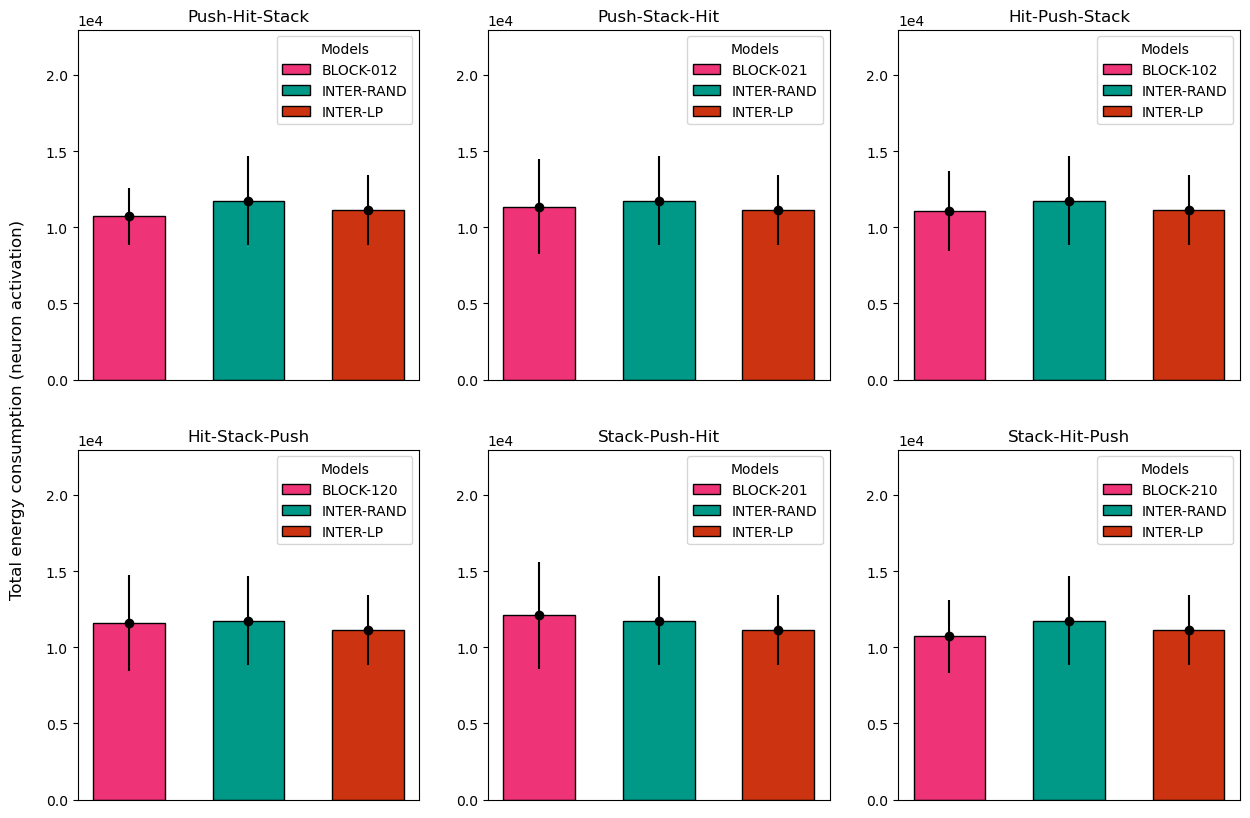

In [8]:
f, axes = plt.subplots(2, 3, figsize=[15, 10])
model_loss_mean = np.mean(model_losses_seeds, axis=1)
model_loss_std = np.std(model_losses_seeds, axis=1)
model_energy_mean = np.mean(model_energies_seeds, axis=1)
model_energy_std = np.std(model_energies_seeds, axis=1)

for a, ax in enumerate(axes.flatten()):
    for i, model in enumerate(models):
        label_name = legend_label[i] + task_order[a] if model == "blocked" else legend_label[i]
        ax.bar(model, model_energy_mean[a][i], width=0.6, label="{}".format(label_name), color=model_colors[model], edgecolor="black")
        ax.errorbar(model, model_energy_mean[a][i], yerr=model_energy_std[a][i], fmt="o", color="black")
    ax.set_title(task_order_names[a])
    ax.set_ylim([0, 23000])
    ax.set_xticks([])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.legend(title='Models')
f.supylabel('Total energy consumption (neuron activation)', x=0.08)
plt.savefig("{}/allseeds-energy.png".format(plot_subpath), bbox_inches='tight')
plt.show()

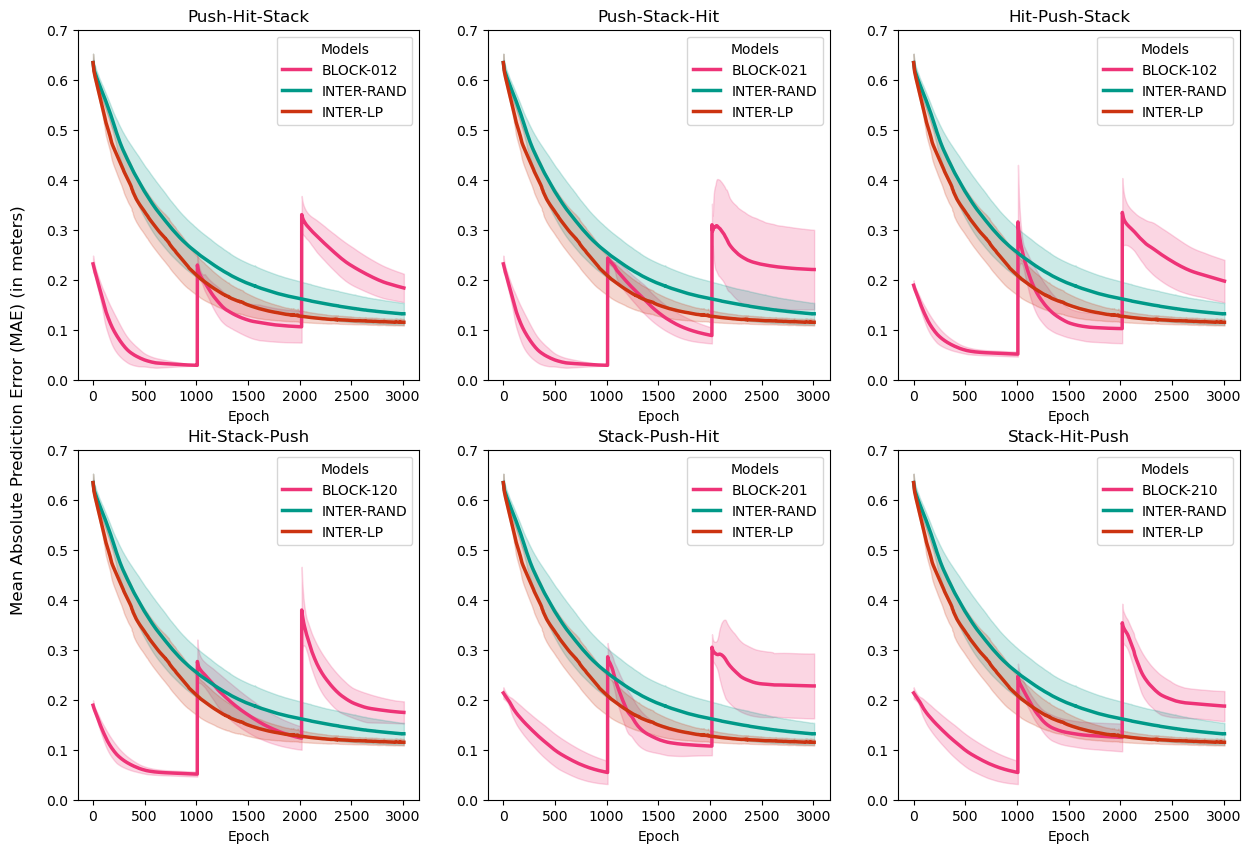

In [9]:
f, axes = plt.subplots(2, 3, figsize=[15, 10])
for a, ax in enumerate(axes.flatten()):
    for i, model in enumerate(models):
        label_name = legend_label[i] + task_order[a] if model == "blocked" else legend_label[i]
        ax.plot(range(epoch + pre_train), model_loss_mean[a][i], label="{}".format(label_name), color=model_colors[model],  lw=2.5)
        ax.fill_between(range(epoch + pre_train), model_loss_mean[a][i] - model_loss_std[a][i],
                         model_loss_mean[a][i] + model_loss_std[a][i], alpha=0.2, color=model_colors[model])
    ax.set_xlabel("Epoch")
    ax.set_title(task_order_names[a])
    ax.legend(title='Models')
    ax.set_ylim([0, 0.7])
f.supylabel('Mean Absolute Prediction Error (MAE) (in meters)', x=0.08)
plt.savefig("{}/allseeds-loss.png".format(plot_subpath), bbox_inches='tight')
plt.show()